In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import json
from pprint import pprint
import io
import pickle
import os
import PIL 
import PIL.Image as pImage
from fastai.vision.all import *
import random
print("done")

ModuleNotFoundError: No module named 'PIL'

In [ ]:
def dataset_creator(path):
  file_names = []
  for filename in os.listdir(path):
      if filename.endswith(".bmp"):
          file_names.append(os.path.join(path, filename))
      else:
          continue
  return file_names

In [39]:
data_path = "/work/07925/alaukik/LeukemiaDataset/C-NMC_training_data/CombinedData"
leuk_data = dataset_creator(data_path + '/all')
no_leuk_data = dataset_creator(data_path + '/hem')


In [40]:
# Selects random images from each list and concatenates list to create overall dataset
#fix this!!!
random.seed(77)
leuk_data_rand = random.sample(set(leuk_data), 3390)
no_leuk_data_rand = random.sample(set(no_leuk_data), 3390)
full_data = list(leuk_data_rand) + list(no_leuk_data_rand)
labels_ls = ['all']*3390 + ['hem']*3390

#Checking that labels match files
print(full_data[250])
print(full_data[251])
print(full_data[249])
print(labels_ls[250], labels_ls[251], labels_ls[249])

/work/07925/alaukik/frontera/LeukemiaDataset/C-NMC_training_data/CombinedData/hem/UID_H23_19_6_hem.bmp
/work/07925/alaukik/frontera/LeukemiaDataset/C-NMC_training_data/CombinedData/hem/UID_H46_3_1_hem.bmp
/work/07925/alaukik/frontera/LeukemiaDataset/C-NMC_training_data/CombinedData/all/UID_68_31_3_all.bmp
hem hem all


In [41]:
def image_to_arr_of_numpy_arr(data_array):
  try:
    i=0
    matrix_2d = []
    '''
    matrix_2d = np.array(Image.open(data_array[0]))
    while i < len(data_array):
      if matrix_2d.shape == (257,257,3):
        break
      matrix_2d = np.array(Image.open(data_array[i]))
      i += 1
    '''

    #print(matrix_2d.shape)
    while i < len(data_array):
      image = np.array(pImage.open(data_array[i]))
      if image.shape == (257,257,3):
        matrix_2d.append(image)
      i += 1
    matrix_2d = np.array(matrix_2d)
    #print(matrix_2d.shape)
    
    return matrix_2d

  except TypeError:
    print('input Data array cannot be empty or null')
    return

<class 'type'>


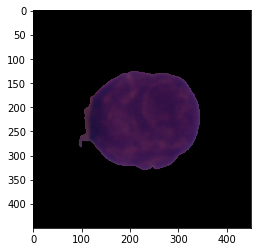

In [42]:
image = mpimg.imread(data_path + '/all/UID_1_1_1_all.bmp')
print(type)
plt.imshow(image)
plt.show()

In [43]:
np.random.seed(32)
data = ImageDataLoaders.from_lists(data_path, full_data, labels=labels_ls, valid_pct=0.2,
      batch_tfms= [*aug_transforms(),Normalize.from_stats(*imagenet_stats)], bs = 64, num_workers=4) 
#TRY THIS FOR LABELS (2/5 Meeting): https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_lists 

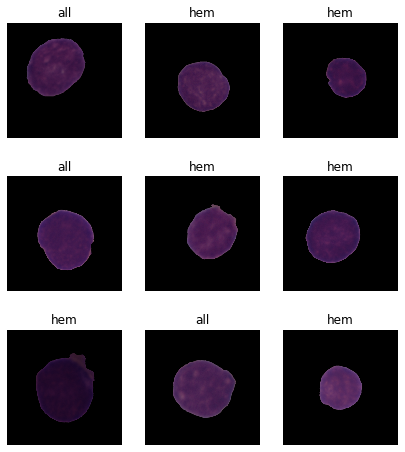

In [44]:
data.show_batch(nrows=3, figsize=(7,8))
#data.label_list

In [45]:
#number of classifications
print(data.c)

2


In [46]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate) #metrics = [] 

In [47]:
learn.fit_one_cycle(4, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.197089,2.836699,0.410000,00:05
1,1.066664,1.773054,0.550000,00:05
2,0.932427,4.455571,0.590000,00:05
3,0.880895,4.642710,0.590000,00:05


In [48]:
learn.save('stage-1')

Path('/work/07925/alaukik/frontera/LeukemiaDataset/C-NMC_training_data/CombinedData/models/stage-1.pth')

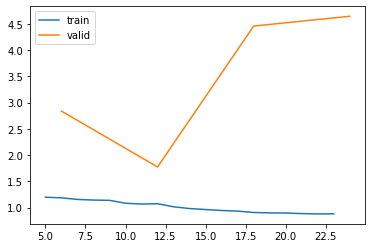

In [49]:
learn.recorder.plot_loss()
learn.unfreeze()

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=6.309573450380412e-07)

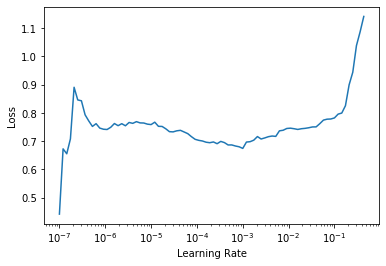

In [52]:
#lr = learn.recorder.min_grad_lr
learn.lr_find()

In [53]:
#figure out better way for lr
learn.fit_one_cycle(10, 0.00010000000474974513)

epoch,train_loss,valid_loss,error_rate,time
0,0.701905,1.358828,0.440000,00:06
1,0.687202,3.796519,0.590000,00:06
2,0.724577,5.262445,0.590000,00:06
3,0.705962,0.558334,0.260000,00:06
4,0.681381,0.620380,0.290000,00:06
5,0.656674,0.627603,0.220000,00:06
6,0.631171,0.601602,0.170000,00:06
7,0.617182,0.669760,0.240000,00:06
8,0.605181,0.829488,0.280000,00:06
9,0.587938,0.795915,0.280000,00:06


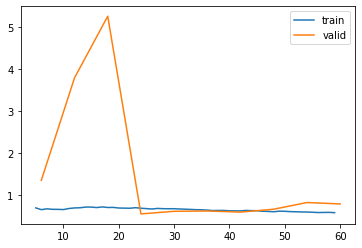

In [54]:
learn.recorder.plot_loss()

In [55]:
learn.save('stage-2')

Path('/work/07925/alaukik/frontera/LeukemiaDataset/C-NMC_training_data/CombinedData/models/stage-2.pth')

In [56]:
learn.load('stage-2')

In [57]:
interp = ClassificationInterpretation.from_learner(learn)

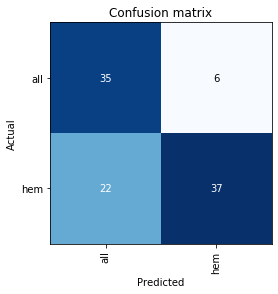

In [58]:
interp.plot_confusion_matrix()

In [59]:
from fastai.vision.widgets import ImageClassifierCleaner

ModuleNotFoundError: No module named 'fastai.widgets'

In [ ]:
#ds, idxs = DatasetFormatter().from_toplosses(learn)
#ImageCleaner(ds, idxs, data_path)

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

# Hook class
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()


def visualize_cnn_by_cam(learn, index):
  x, y = learn.dls.valid_ds[index]
  x.save("./output/image_" + str(index) + ".png")
  x = transforms.ToTensor()(x).unsqueeze(0)
  #for t in tfms:
  #  x = t(x, split_idx=0)
  cls = y
  with HookBwd(learn.model[0]) as hookg:
      with Hook(learn.model[0]) as hook:
          output = learn.model.eval()(x)
          act = hook.stored
      output[0,cls].backward()
      grad = hookg.stored

  # Take the mean of the gradients
  w = grad[0].mean(dim=[1,2], keepdim=True)
  cam_map = (w * act[0]).sum(0)

  # Show the plot
  x_dec = TensorImage(data.train.decode((x,))[0][0])
  _,ax = plt.subplots()
  x_dec.show(ctx=ax)
  ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,450,450,0),
                interpolation='bilinear', cmap='magma')
  plt.savefig("./output/heatmap" +  str(index) + ".png")

In [ ]:
visualize_cnn_by_cam(learn, 2)
#num_leuk = len (leuk_data)
#num_no_leuk = len (no_leuk_data)       
for idx in range(10): # Range can be whatever you want, or select a specific image of interest given its index
    visualize_cnn_by_cam(learn, idx)